In [227]:
import torch
import numpy as np
import pandas as pd
from data.Architectures.VGG16_FeaturesOnly import FeaturesOnly

In [235]:
# Create Train-Test Split
# Load the CSV file (Upload your file)
train_csv = "../train_30h.csv" 
df = pd.read_csv(train_csv)

# Extract features (from the third column to the second last column)
X_train = df.iloc[:, 2:-1]  # Adjust indexing based on your file structure
y_train = df.iloc[:, -1]  # Last column as labels

# Store feature names BEFORE converting X_train to a tensor
feature_names = X_train.columns.tolist()  # Ensure this is a DataFrame before tensor conversion

test_csv = "../test_30h.csv" 
test_df = pd.read_csv(test_csv)

X_test = test_df.iloc[:, 2:-1]
y_test = test_df.iloc[:, -1]

In [229]:
# Convert to Torch Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to("cuda")
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to("cuda") 

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to("cuda")
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to("cuda")  # Change dtype if using regression

In [230]:
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)

        if y_pred.shape[1] == 1:  # Binary Classification (Single output neuron)
            y_pred = (y_pred > 0.5).int()
            y_pred = y_pred.squeeze(dim=1)  # Remove extra dimension
        else:  # Multi-Class Classification
            y_pred = y_pred.argmax(dim=1)  # Get class index

        accuracy = (y_pred == y).float().mean().item()
    return accuracy

In [231]:
model = torch.load(r"C:\Users\parde\PycharmProjects\The-model\DeepFakeModel_lr=0.0018225174677877769_bs=16_drop=0.62_layers=4_valloss=0.0768.pth",  map_location=torch.device('cuda'))
model.eval()

C:\Users\parde\AppData\Local\Temp\ipykernel_28976\1049853142.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(r"C:\Users\parde\PycharmProjects\The-mode

FeaturesOnly(
  (features_norm): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (dense_layers): Sequential(
    (linear_0): Linear(in_features=156, out_features=104, bias=True)
    (relu_0): ReLU()
    (drop_0): Dropout(p=0.6155282255084615, inplace=False)
    (linear_1): Linear(in_features=104, out_features=52, bias=True)
    (relu_1): ReLU()
    (drop_1): Dropout(p=0.6155282255084615, inplace=False)
    (linear_2): Linear(in_features=52, out_features=1, bias=True)
  )
)

In [217]:
# Compute Baseline Accuracy
baseline_acc = evaluate_model(model, X_test_tensor, y_test_tensor)

# Compute Permutation Importance
feature_importance = []
num_repeats = 500  # How many times to shuffle each feature

for col in range(X_test.shape[1]):  # Iterate over each feature
    acc_drops = []
    
    for _ in range(num_repeats):
        X_test_permuted = X_test_tensor.clone()  # Clone to avoid modifying original test set
        X_test_permuted[:, col] = X_test_permuted[:, col][torch.randperm(X_test_permuted.shape[0])]  # Shuffle feature
        
        permuted_acc = evaluate_model(model, X_test_permuted, y_test_tensor)
        acc_drops.append(baseline_acc - permuted_acc)  # Difference from baseline accuracy
    
    feature_importance.append(np.mean(acc_drops))  # Average over repeats

In [222]:
# Store and Display Results
perm_df = pd.DataFrame({"Feature": X_test.columns, "Importance": feature_importance})
perm_df = perm_df.sort_values(by="Importance", ascending=False)
print(perm_df.head(35))

              Feature  Importance
23       median_16000    0.047040
26       variance_255    0.028418
51          std_16000    0.017543
39            std_150    0.010870
27       variance_300    0.010524
49           std_8000    0.007275
96         mfcc0_mean    0.005643
112       mfcc16_mean    0.005076
12         median_255    0.004452
67          mfcc1_std    0.003291
116       mfcc20_mean    0.003290
7           F1Formant    0.002712
41            std_300    0.002685
47           std_4000    0.002267
22       median_12000    0.002227
46           std_3500    0.002219
50          std_12000    0.002202
123       mfcc27_mean    0.002143
118       mfcc22_mean    0.001818
25       variance_150    0.001773
105        mfcc9_mean    0.001751
38             std_85    0.001667
21        median_8000    0.001647
42            std_700    0.001614
94         mfcc28_std    0.001575
24        variance_85    0.001521
40            std_255    0.001423
127         mfcc1_var    0.001328
99         mfc

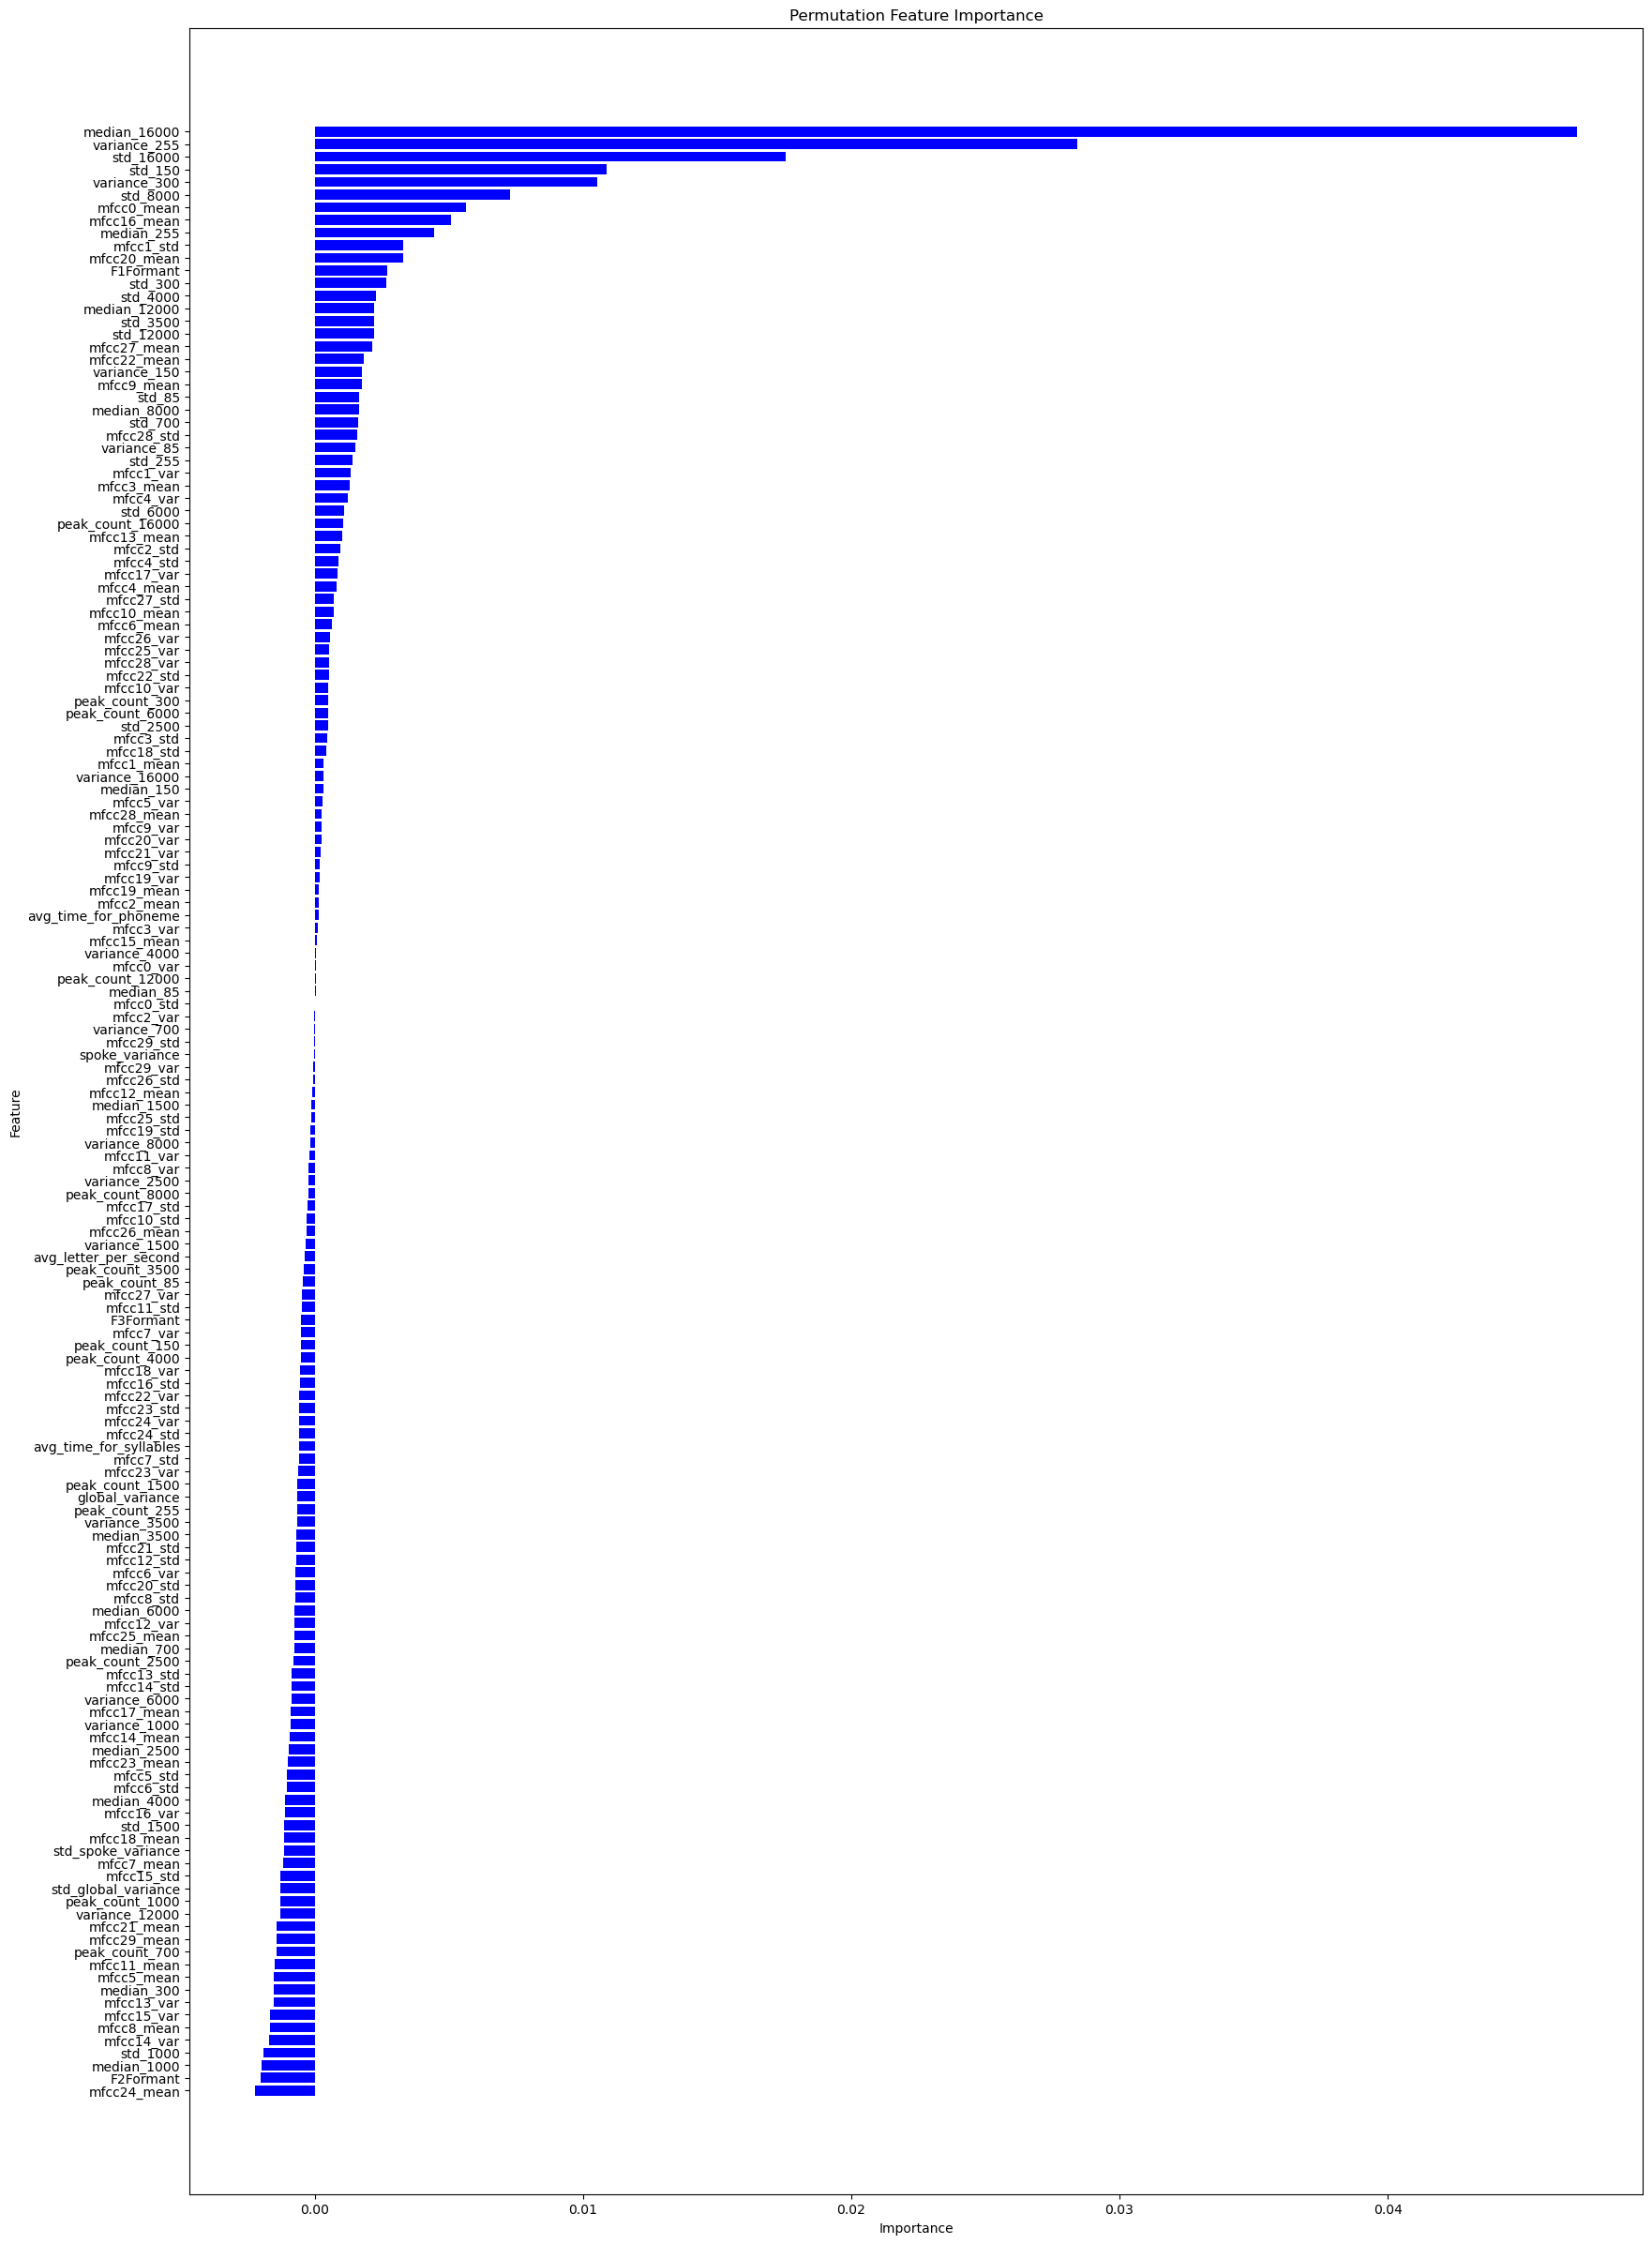

In [224]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 30))
plt.barh(perm_df["Feature"], perm_df["Importance"], color="blue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.show()
